In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install pillow
!{sys.executable} -m pip install SimpleITK
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install qtconsole
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install graphviz
!pip install PyDrive

! pip install kaggle
! pip install nvidia-smi
! gdown --id 11dzPv9LxegCDJTNE0RVCJD9hi2sxjQb4
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'moulhanout/stanford-dogs-dataset'
! unzip stanford-dogs-dataset

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1357.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1367.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13738.jpg  
  inflating: images/

In [23]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from keras import layers, Input
from keras.layers import Dense, InputLayer, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from  matplotlib import pyplot as plt
#import matplotlib.image as mpimg
#%matplotlib inline
import scipy.io
from PIL import Image, ImageOps
#from time import time
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.models import Model
import gdown

In [3]:
NB_CLASSES = 120
COLOR_MODE = "rgb"
IMAGE_FOLDER_PATH = os.path.join("images/Images")

In [6]:
test_list = scipy.io.loadmat('lists/test_list.mat')
TestList_df=pd.DataFrame()
TestList_df[['NomImage']]=test_list['file_list']
TestList_df[['ClasseImage']]=test_list['labels']
TestList_df

,NomImage,ClasseImage
0,[n02085620-Chihuahua/n02085620_2650.jpg],1
1,[n02085620-Chihuahua/n02085620_4919.jpg],1
2,[n02085620-Chihuahua/n02085620_1765.jpg],1
3,[n02085620-Chihuahua/n02085620_3006.jpg],1
4,[n02085620-Chihuahua/n02085620_1492.jpg],1
...,...,...
8575,[n02116738-African_hunting_dog/n02116738_4991....,120
8576,[n02116738-African_hunting_dog/n02116738_3024....,120
8577,[n02116738-African_hunting_dog/n02116738_3635....,120
8578,[n02116738-African_hunting_dog/n02116738_2988....,120


In [7]:
TestList_df[['NomImage']]=TestList_df[['NomImage']].applymap(lambda x: x[0])
print(TestList_df.head())

                                 NomImage  ClasseImage
0  n02085620-Chihuahua/n02085620_2650.jpg            1
1  n02085620-Chihuahua/n02085620_4919.jpg            1
2  n02085620-Chihuahua/n02085620_1765.jpg            1
3  n02085620-Chihuahua/n02085620_3006.jpg            1
4  n02085620-Chihuahua/n02085620_1492.jpg            1


In [8]:
def getClassLibelle(x):
    classe_1 = x.split("/")
    classe_1 = classe_1[0]
    classe_2 = classe_1.split("-")
    return classe_2[1]

In [9]:
TestList_df[['ClasseImageLibelle']]=TestList_df[['NomImage']].applymap(getClassLibelle)
TestList_df

,NomImage,ClasseImage,ClasseImageLibelle
0,n02085620-Chihuahua/n02085620_2650.jpg,1,Chihuahua
1,n02085620-Chihuahua/n02085620_4919.jpg,1,Chihuahua
2,n02085620-Chihuahua/n02085620_1765.jpg,1,Chihuahua
3,n02085620-Chihuahua/n02085620_3006.jpg,1,Chihuahua
4,n02085620-Chihuahua/n02085620_1492.jpg,1,Chihuahua
...,...,...,...
8575,n02116738-African_hunting_dog/n02116738_4991.jpg,120,African_hunting_dog
8576,n02116738-African_hunting_dog/n02116738_3024.jpg,120,African_hunting_dog
8577,n02116738-African_hunting_dog/n02116738_3635.jpg,120,African_hunting_dog
8578,n02116738-African_hunting_dog/n02116738_2988.jpg,120,African_hunting_dog


In [10]:
def remove_corupted_files(DataFrame):
    num_skipped = 0
    num_absent = 0
    is_jfif = False
    for FileName in DataFrame['NomImage']:
        fpath = os.path.join(IMAGE_FOLDER_PATH, FileName)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            fobj.close()
        except:
            #retire une image qui n'existe pas
            #print(FileName)
            num_absent += 1
            DataFrame = DataFrame[DataFrame['NomImage']!=FileName]
            

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            DataFrame = DataFrame[DataFrame['NomImage']!=FileName]

    print("Nombre images supprimées: %d" % num_skipped)
    print("Nombre images absentes: %d" % num_absent)
    return DataFrame

In [11]:
TestList_df_2 = remove_corupted_files(TestList_df)

Nombre images supprimées: 4
Nombre images absentes: 0


Chargement du modèle entraîné:

In [39]:
filename = "drive/MyDrive/Colab Notebooks/dog_classifier.h5"
prediction_model = keras.models.load_model(filename)

Récupération du tableau des labels pour décoder les prédictions:

In [77]:
import pickle
f=open('drive/MyDrive/Colab Notebooks/label_map.txt','rb') #opening the file to read the data in the binary form
dog_labels_array=pickle.load(f)

Récupération d'une image aléatoirement:

In [108]:
TestRandomImage=TestList_df_2.sample(n=1, axis=0)
img_path = os.path.join(IMAGE_FOLDER_PATH,TestRandomImage['NomImage'].item())

Conversion de l'image en array et preprocessing:

In [109]:
img = load_img(img_path, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

Prédiction de la race du chien :

Race prédite : giant_schnauzer
Race réelle :  giant_schnauzer


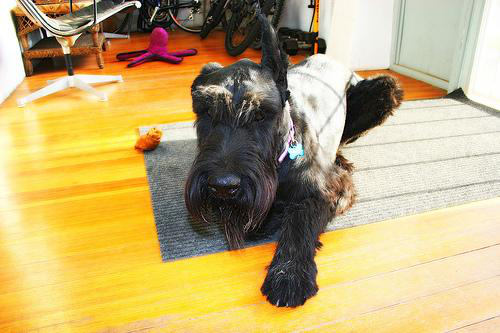

In [110]:
probability = prediction_model.predict(img)
predicted_dog = probability.argmax(axis=-1)

print('Race prédite :',list(dog_labels_array.keys())[list(dog_labels_array.values()).index(predicted_dog[0])])
print('Race réelle : ', TestRandomImage['ClasseImageLibelle'].item())
Image.open(img_path)